<H1> Segmenting and Clustering Neighborhoods in Toronto

<H2> Part 1 : Webscraping using BeautifulSoup package to create a dataframe containing list of postal codes in Canada

<H3> Webscraping the wikipedia page containing the list of postal codes in Canada

In [1]:
import requests 
from bs4 import BeautifulSoup 

URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
r = requests.get(URL) 

soup = BeautifulSoup(r.content, 'html5lib') 

<H3> Creating a pandas DataFrame containing the list

In [2]:
import pandas as pd

table = soup.find_all('table')[0]
rid = 0
col_list = []

# Retrieving the column headers from the page
for header in table.find_all('th'):
    col_list.append(header.get_text())

col_list = list(map(lambda x:x.strip(),col_list))

# Creating an empty dataframe with just columns specified
df = pd.DataFrame(columns=col_list)

my_list = []

# Inserting rows into the dataframe from the content of the webpage
for row in table.find_all('tr'):
    columns = row.find_all('td')
    if columns != []:
        for column in columns:
            my_list.append(column.get_text())
            my_list = list(map(lambda x:x.strip(),my_list))
        df.loc[rid] = my_list
    my_list = []
    rid += 1

# Displaying the first 5 rows of the data
df.head()

,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


In [3]:
# Shape of the dataset
df.shape

(287, 3)

<H3> Conditions to create the final dataframe with the postal codes of Toronto.

- Dataframe to contain 3 columns : PostalCode, Borough, and Neighbourhood.
- Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
- Check if a cell has a borough but a 'Not assigned' neighbourhood. If found, make the neighbourhood same as the borough.
- Combine neighbourhoods with same Postal code

In [4]:
# Check the 3 columns
df.columns

Index(['Postcode', 'Borough', 'Neighbourhood'], dtype='object')

In [5]:
# Check for 'Not assigned' Boroughs and remove them
new_df = df[df['Borough'] != 'Not assigned']

In [6]:
# Check if there are any 'Not assigned' neighbourhoods (Already checked and there weren't any)
new_df[new_df['Neighbourhood'] == 'Not assigned']

,Postcode,Borough,Neighbourhood


In [7]:
# Combining neighbourhoods with the same postal code
new_df = new_df.groupby(['Postcode', 'Borough']).apply(lambda x: list(x['Neighbourhood']))

# Creating a separate dataframe with the outcome of 'groupby'
df_final = pd.DataFrame(new_df)
df_final.reset_index(inplace=True)

# Renaming the column containing the list of neighbourhoods with the same postal code
df_final.rename(columns = {0:'Neighbourhood'}, inplace=True)

# This step is just to remove the list brackets '[]' from the column values
df_final['Neighbourhood'] = df_final['Neighbourhood'].apply(lambda x : ", ".join(x))

# Display the top 5 rows of final dataset after applying all operations
df_final.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


<H3> Number of rows in the final dataframe created after webscraping

In [8]:
df_final.shape

(103, 3)

<H2> Part 2 : Adding the Geographical coordinates of each Postal code to the dataframe

<H3> Reading the csv file that has the geographical coordinates of each postal code

<b> Note: </b> Since the Geocoder Python package was very unreliable and took a lot of time in getting the geographical coordinates for each postal code, I've taken the liberty of using the csv file provided.

In [9]:
# Reading the file with the geographical coordinates
lat_lan_df = pd.read_csv('Geospatial_Coordinates.csv')

# Displaying the top 5 rows
lat_lan_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


<H3> Merging both the dataframes : df_final (Postcode, Borough, Neighbourhood) & lat_lan_df (Postal Code, Latitude, Longitude) with the common column 'Postcode'

In [10]:
df_merge = df_final.merge(lat_lan_df, how='inner', left_on='Postcode', right_on='Postal Code')
df_merge.drop(['Postal Code'], axis=1, inplace=True)

<H3> Final Dataframe : Postcode, Borough, Neighbourhood, Latitude, Longitude

In [11]:
# Displaying the top 5 rows of the merged Dataframe
df_merge.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [12]:
df_merge.shape

(103, 5)

<H2> Part 3 : Explore and cluster the neighborhoods in Toronto

<H3> Determining the geographical coordinates of Toronto for creating the map

In [13]:
from geopy.geocoders import Nominatim

address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of Toronto is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto is 43.653963, -79.387207.


<H3> Marking all the neighbourhoods from the dataframe on the map of Toronto

In [14]:
import folium

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_merge['Latitude'], df_merge['Longitude'], df_merge['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<H3> For the purpose of analysing the clusters in Toronto as part of this assignment, I'm only taking Boroughs that contain the word 'Toronto '

In [15]:
toronto_data = df_merge[df_merge['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_data

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


<H3> Marking only the neighbourhoods which contain 'Toronto' in the Borough on the map of Toronto

In [16]:
# create map of Manhattan using latitude and longitude values
map_fin_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_fin_toronto)  
    
map_fin_toronto

<H3> Defining credentials for using Foursquare API

In [17]:
CLIENT_ID = '<removed>' # your Foursquare ID
CLIENT_SECRET = '<removed>' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

#Note : I've removed the credentials after executing the cell

Defining a function 'getNearbyVenues' for obtaining the venues using Foursquare API by passing the elements of dataframe containing 'Toronto' in Borough. This function would also create a new dataframe containing the venue, it's geographical coordinates and the category of the venue for the corresponding neighbourhood

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<H3> Dataframe containing venue related details using the function

In [19]:
# Function call for creating dataframe with venues
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

# Displaying top 5 rows
toronto_venues.head()

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
2,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
3,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


Number of venues for each Neighbourhood

In [20]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,17,17,17,17,17,17
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
"Cabbagetown, St. James Town",48,48,48,48,48,48
Central Bay Street,82,82,82,82,82,82
"Chinatown, Grange Park, Kensington Market",85,85,85,85,85,85
Christie,18,18,18,18,18,18


In [21]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 238 uniques categories.


<H3> Analyzing each neighbourhood 

In [22]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
toronto_onehot.shape

(1717, 239)

<H3> Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [24]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()

# Displaying top 5 rows
toronto_grouped.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.0,...,0.0,0.0,0.0,0.020000,0.0,0.0,0.01,0.0,0.01,0.0
1,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.018182,0.0,0.0,0.00,0.0,0.00,0.0
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.00,0.0
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.00,0.0
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.071429,0.071429,0.071429,0.142857,0.071429,0.071429,0.00,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.00,0.0


In [25]:
toronto_grouped.shape

(39, 239)

<H3> Function to sort the venues in descending order

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

<H3> Creating a new dataframe and displaying the top 10 venues for each neighbourhood.

In [27]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Café,Bar,Thai Restaurant,Cosmetics Shop,Steakhouse,Sushi Restaurant,Gym,Asian Restaurant
1,Berczy Park,Coffee Shop,Farmers Market,Cocktail Bar,Beer Bar,Bakery,Seafood Restaurant,Restaurant,Cheese Shop,Café,Diner
2,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Gym,Bakery,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant,Burrito Place
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Skate Park,Garden Center,Burrito Place,Fast Food Restaurant,Farmers Market,Auto Workshop,Spa,Garden,Restaurant
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Boutique,Coffee Shop,Airport,Airport Food Court,Airport Gate,Airport Service,Airport Terminal,Bar,Harbor / Marina


<H3> Running K-means to cluster the neighborhood into 4 clusters.

In [28]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       2, 1, 3, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

<H3> Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [29]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() 

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Pub,Other Great Outdoors,Neighborhood,Health Food Store,Trail,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Furniture / Home Store,Restaurant,Ice Cream Shop,Diner,Pub,Caribbean Restaurant
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1,Park,Sandwich Place,Pizza Place,Gym,Board Shop,Brewery,Burrito Place,Pub,Movie Theater,Sushi Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Bakery,Gastropub,Italian Restaurant,American Restaurant,Brewery,Yoga Studio,Latin American Restaurant,Fish Market
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,2,Gym / Fitness Center,Park,Bus Line,Swim School,Yoga Studio,Dim Sum Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


<H3> Visualizing the resulting clusters on the map

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Visualizing the clusters made on the above map shows us that most of the neighbourhoods fall into a single cluster. It could be due to many reasons, one of which could be due to the 'number of clusters' chosen for the K-means model. Another reasonable explanation might be that a different algorithm should be used instead of K-means. 

To be absolutely sure, let us determine an optimal value of 'K' for use in K-Means Cluster Algorithm. The Elbow Method is one of the most popular methods to determine this optimal value of k. 
Different values of 'Distortion' & 'Inertia' are calculated using a range of K values.
- Distortion is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used. 
- Inertia is the sum of squared distances of samples to their closest cluster center.

<H3> Determining the optimal value of K

In [31]:
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering) 
    kmeanModel.fit(toronto_grouped_clustering)

    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 
                    'euclidean'),axis=1)) / toronto_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

    mapping1[k] = sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 
                'euclidean'),axis=1)) / toronto_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

<H3> Elbow Method using Distortion

In [32]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 0.24202473977030417
2 : 0.22277706440230383
3 : 0.205725095717065
4 : 0.19066966495408177
5 : 0.17784915213356894
6 : 0.16548672627845468
7 : 0.1577230629439352
8 : 0.14313576427175023
9 : 0.13741589771844046


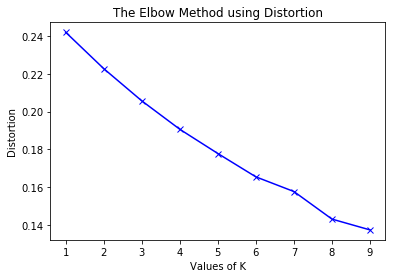

In [33]:
# Plotting the graph
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

<H3> Elbow Method using Inertia

In [34]:
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

1 : 3.0633541474702506
2 : 2.577397168410607
3 : 2.1009951826211015
4 : 1.796628576100318
5 : 1.671628576100318
6 : 1.3500756903344922
7 : 1.2641585389987595
8 : 1.0928568764686375
9 : 1.0032816848926225


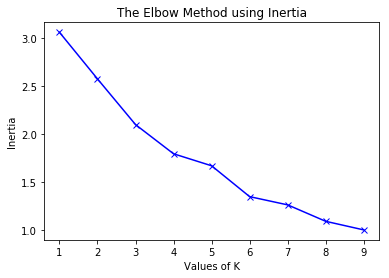

In [35]:
# Plotting the graph
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

It becomes clear from both the above graphs that there is no clear elbow for the different values of K. 
Let us also examine each cluster and determine the discriminating venue categories that distinguish each cluster before we make our conclusions for this.

Based on the defining categories, we might be able to explain dominance of a single cluster.

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,0,Home Service,Garden,Music Venue,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Dessert Shop,Doner Restaurant


In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,1,Pub,Other Great Outdoors,Neighborhood,Health Food Store,Trail,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
1,East Toronto,1,Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Furniture / Home Store,Restaurant,Ice Cream Shop,Diner,Pub,Caribbean Restaurant
2,East Toronto,1,Park,Sandwich Place,Pizza Place,Gym,Board Shop,Brewery,Burrito Place,Pub,Movie Theater,Sushi Restaurant
3,East Toronto,1,Café,Coffee Shop,Bakery,Gastropub,Italian Restaurant,American Restaurant,Brewery,Yoga Studio,Latin American Restaurant,Fish Market
5,Central Toronto,1,Gym,Hotel,Breakfast Spot,Food & Drink Shop,Sandwich Place,Department Store,Park,Cosmetics Shop,Concert Hall,Electronics Store
6,Central Toronto,1,Clothing Store,Coffee Shop,Café,Restaurant,Rental Car Location,Salon / Barbershop,Mexican Restaurant,Fast Food Restaurant,Chinese Restaurant,Diner
7,Central Toronto,1,Sandwich Place,Dessert Shop,Pizza Place,Gym,Italian Restaurant,Café,Coffee Shop,Sushi Restaurant,Costume Shop,Farmers Market
9,Central Toronto,1,Coffee Shop,Pub,Light Rail Station,American Restaurant,Supermarket,Bagel Shop,Restaurant,Fried Chicken Joint,Sports Bar,Sushi Restaurant
11,Downtown Toronto,1,Park,Restaurant,Coffee Shop,Pizza Place,Bakery,Italian Restaurant,Café,Pub,Liquor Store,Playground
12,Downtown Toronto,1,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Pub,Men's Store,Mediterranean Restaurant,Hotel,Gastropub


In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,2,Gym / Fitness Center,Park,Bus Line,Swim School,Yoga Studio,Dim Sum Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
10,Downtown Toronto,2,Park,Trail,Playground,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Yoga Studio
23,Central Toronto,2,Trail,Park,Sushi Restaurant,Jewelry Store,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio


In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,3,Trail,Tennis Court,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


<H3> Conclusion 

After examining the above defined categories, one might be able to explain the dominance of 'Cluster Label : 1' due to the dominance of 'Coffee shops' and 'Cafe' whereas no such venues exist in any of the other clusters. Eaxmining the other clusters, we do notice that they contain 'unique' venues such as 'Home service', 'Garden', 'Tennis court' etc which are not present in the dominant cluster. So, it would be reasonable to say that neighbourhoods in Toronto majorly fall into a single cluster.